# P2 Exploration 

Basic exploration will be done in this jupyter notebook. Our exploration is divided into 4 major parts generally and based on the primary events we considered : 
- General exploration
- Feminism
- Space exploration 
- WW2

We would like to finetune DistilBERT on our dataset in order to determine whether movie passed the bechdel test or not:
https://huggingface.co/docs/transformers/en/tasks/sequence_classification 

helpers.py file has intermediate functions that helps us write some code.



In [1]:
from helpers import *
import pandas as pd
import matplotlib.pyplot as plt
 
# Just fill this with wherever is your main data folder is (copy the path just before 'MovieSummaries'):
file_source = "/Users/shrinidhivelan/Downloads/"

# Same goes for the reviews dataset : but simply copy the entire path of where your reviews data is... 
reviews_path = "/Users/shrinidhivelan/Downloads/TMDB_movie_dataset_v11.csv"

# replace the following by the direct path of where your bechdel test movie data is:
bechdel_path = "/Users/shrinidhivelan/Downloads/movies.csv"
bechdel_path2 = "/Users/mariannecivitardevol/Documents/EPFL/Masters/Year 2/ADA copy/MovieSummaries/movies_feminism.csv"

### creating dataset by extracting the main CMU data 
MovieMetadata_df, CharacterMetadata_df, names_df, plot_summaries_df, tvTropes_df, merged_df = create_datasets(file_source, reviews_path)
reviews = pd.read_csv(reviews_path)

## 0) General exploration

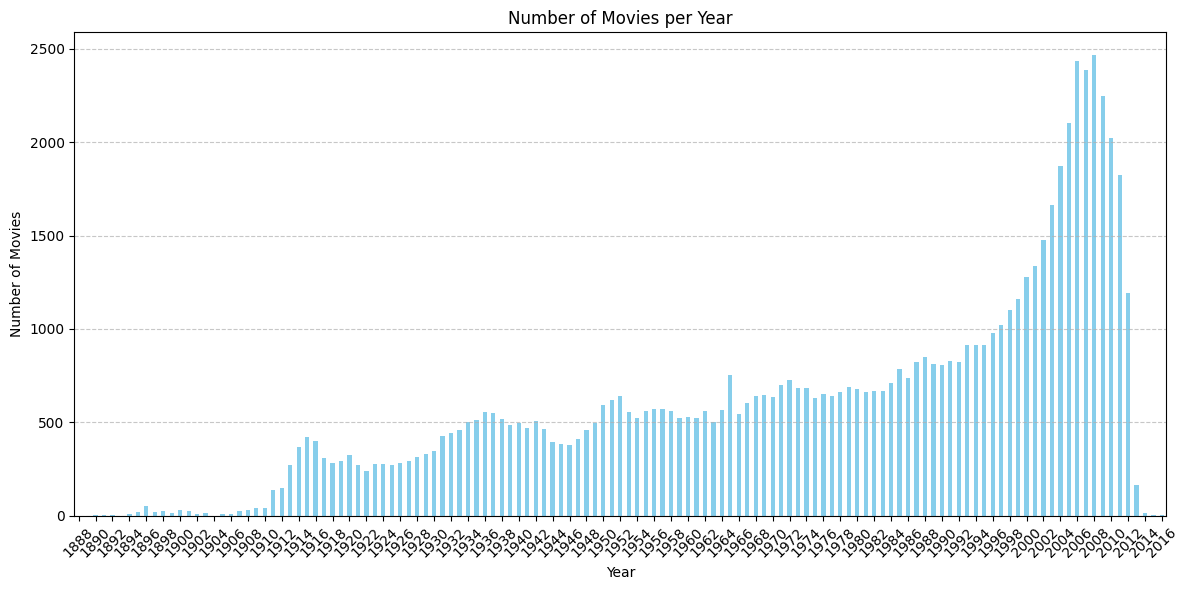

In [4]:
# Count the number of movies per year, ignoring NaN years
movies_per_year = MovieMetadata_df['Year'].value_counts().sort_index()

# Create the bar plot
plt.figure(figsize=(12, 6))
movies_per_year.plot(kind='bar', color='skyblue')
plt.title('Number of Movies per Year')
plt.xlabel('Year')
plt.ylabel('Number of Movies')

# Set the x-ticks to display only every 2nd or 3rd year
plt.xticks(ticks=range(0, len(movies_per_year), 2), labels=movies_per_year.index[::2], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

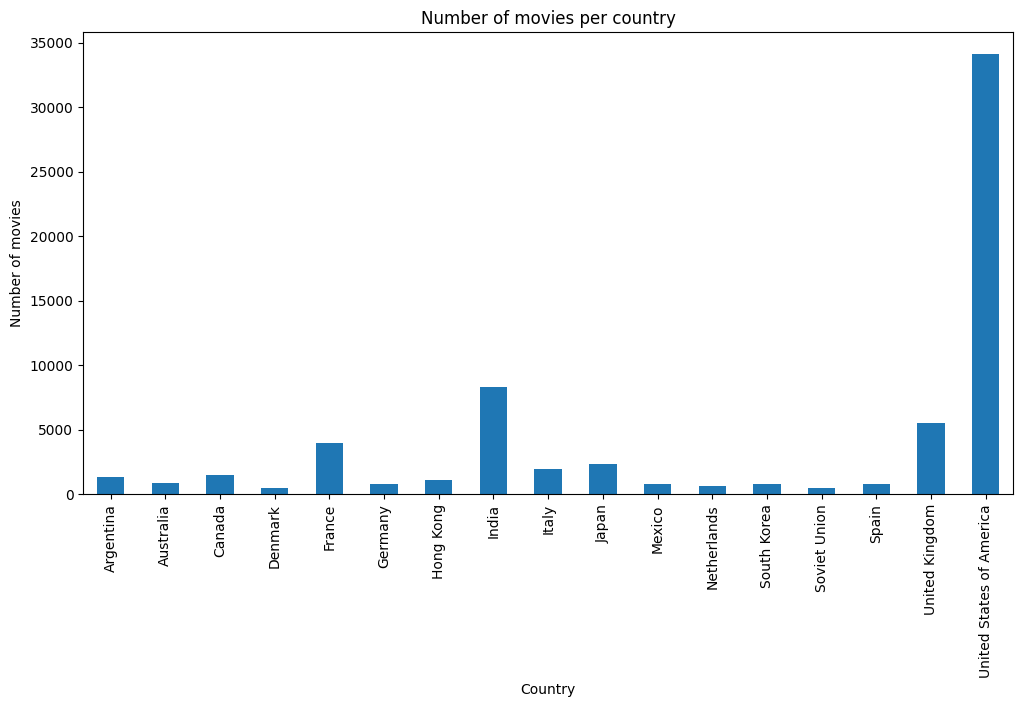

In [2]:
# Analyse the number of movies per countries countries:
countries = MovieMetadata_df["Movie countries (Freebase ID:name tuples)"].values
kept_counted = movie_per_country(countries)

# Plot the movie analysis by country
fig, ax = plt.subplots(figsize=(12, 6))  # Adjust 12 for a wider plot

# Plot the data on the created axis
kept_counted.plot.bar(ax=ax)

plt.title("Number of movies per country")
plt.ylabel("Number of movies")
plt.xlabel("Country")

plt.show()

## 1) Feminism

### Initial analysis and first steps towards labelling using ML

#### We merge the data on the bechdel test : 
following the ideas of the following site 
https://ai.plainenglish.io/predicting-bechdel-test-score-using-machine-learning-7253618a3f8

In [6]:
# The bechdel data contains ~1700 lines, to be separated into train and test sets in order to create a model to predict the binary result
#### 80% train and 20% test for instance, this will be used to merge main data into this : 
bechdel_data = pd.read_csv(bechdel_path)
bechdel_data = bechdel_data[['year', 'title', 'binary','budget']]
bechdel_data_merged = bechdel_data.merge(MovieMetadata_df, how='left', left_on = 'title', right_on = 'Movie name')

# Define the columns to check for NaN values
columns_to_check = [
    'Wikipedia movie ID', 'Freebase movie ID', 'Movie name', 
    'Movie release date', 'Movie box office revenue', 'Movie runtime', 
    'Movie languages (Freebase ID:name tuples)', 
    'Movie countries (Freebase ID:name tuples)', 
    'Movie genres (Freebase ID:name tuples)'
]

# Remove rows where all specified columns are NaN
bechdel_data_merged = bechdel_data_merged.dropna(subset=columns_to_check, how='all')

# Display the DataFrame to confirm rows are removed - around ~300 lines are removed
#display(bechdel_data_merged)

####  a) Using the RF classifier

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

df = bechdel_data_merged  

target = 'result'
features = [
    'year', 'budget', 'Wikipedia movie ID', 'Freebase movie ID', 'Movie name', 
    'Movie release date', 'Movie box office revenue', 'Movie runtime', 
    'Movie languages (Freebase ID:name tuples)', 'Movie countries (Freebase ID:name tuples)', 
    'Movie genres (Freebase ID:name tuples)', 'Year'
]

# Convert 'FAIL' to 0 and 'PASS' to 1 in the 'binary' column
df['result'] = df['binary'].replace({'FAIL': 0, 'PASS': 1})


# Drop rows where target is NaN
df = df.dropna(subset=[target])

# Separate features and target variable (X and y constantly)
X = df[features]
y = df[target]

# Define which columns need specific preprocessing
numeric_features = ['year', 'budget', 'Movie box office revenue', 'Movie runtime', 'Year']
categorical_features = [
    'Wikipedia movie ID', 'Freebase movie ID', 'Movie name', 
    'Movie languages (Freebase ID:name tuples)', 'Movie countries (Freebase ID:name tuples)', 
    'Movie genres (Freebase ID:name tuples)'
]

# Define preprocessors for a simple random forests  model : 
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessors
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)#, random_state=42)

# Define and train the model pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', RandomForestClassifier())])#(random_state=42))])

# Train the model
model.fit(X_train, y_train)

# Step 5: Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC AUC Score: {roc_auc:.2f}")

/var/folders/p6/m1p5k4zj0yn9mk66d_dh7pn40000gn/T/ipykernel_77672/1462372775.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['result'] = df['binary'].replace({'FAIL': 0, 'PASS': 1})


Accuracy: 0.59
F1 Score: 0.45
ROC AUC Score: 0.58


### b) Analyze on second bechdel test dataset

In [3]:
# Create a dataframe with the bechdel data as well as plots
bechdel_data2 = pd.read_csv(bechdel_path2)
# drop the NaN movie plots
plot_summaries_df = plot_summaries_df.dropna(subset=['Summaries'])
merged_bechdel_plot = bechdel_plots_dataset_creation(bechdel_data2, MovieMetadata_df,plot_summaries_df)


In [4]:
# Train a model to classify feminist vs non-feminist movies
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

X = merged_bechdel_plot['Summaries']
y = merged_bechdel_plot['bt_score']
X = X.values.reshape(-1, 1)

#balance the dataset
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)

#flatten the plots
X_res = pd.Series(X_res.flatten())

# split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)


pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, stop_words='english')),
    ('model', LogisticRegression(solver='liblinear', random_state=42)) 
])

# Train the model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Print evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7086614173228346

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.71      0.72       137
           3       0.67      0.71      0.69       117

    accuracy                           0.71       254
   macro avg       0.71      0.71      0.71       254
weighted avg       0.71      0.71      0.71       254



In [5]:
# Analyse the information

# Extract the trained model and vectorizer
tfidf = pipeline.named_steps['tfidf']
model = pipeline.named_steps['model']

# Get feature names and coefficients
feature_names = tfidf.get_feature_names_out()
coefficients = model.coef_.flatten()

# Create a DataFrame to display feature importance
feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False)

# Display the top 10 features
print("Top 20 Features with Positive Influence:")
print(feature_importance.head(20))

print("\nTop 20 Features with Negative Influence:")
print(feature_importance.tail(20))

Top 20 Features with Positive Influence:
       Feature  Coefficient
2968    mother     1.810257
3947    school     1.403096
4133    sister     1.286655
2696      love     1.227711
1649    family     1.053197
155      alice     1.030603
1121  daughter     1.010335
2710      lucy     0.899319
2801      mary     0.897330
4931     women     0.894728
2150     house     0.888381
3547     queen     0.872795
2174   husband     0.868736
209      annie     0.858809
781   children     0.844492
2787  marriage     0.778444
1894     girls     0.749941
2126      home     0.738122
3565    rachel     0.733107
3226   parents     0.732355

Top 20 Features with Negative Influence:
          Feature  Coefficient
2326         jack    -0.568910
549          boys    -0.569498
262        arthur    -0.570290
2109       hitman    -0.585387
1047         crew    -0.589181
4607        tramp    -0.617410
2198  illusionist    -0.622951
2385        joker    -0.629301
2467       killed    -0.633486
2338     japanese  

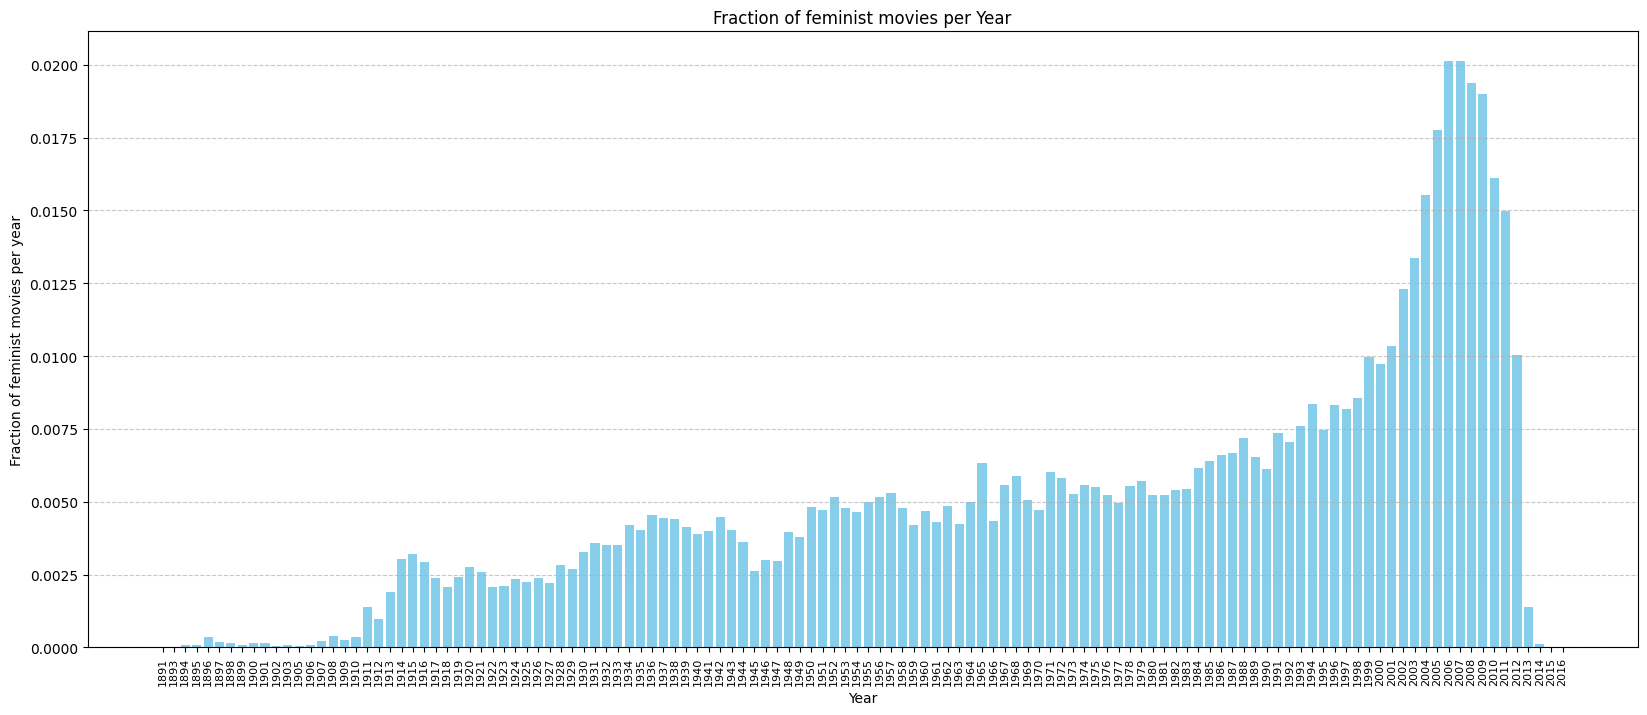

In [11]:
# Predict on all movies
new_predictions = pipeline.predict(plot_summaries_df['Summaries'])

bool_new_predictions = []
for prediction in new_predictions:
    if prediction == 3: 
        bool_new_predictions.append(True)
    else:
        bool_new_predictions.append(False)

# create a new column to keep the prediction
bool_new_predictions = pd.Series(bool_new_predictions)
plot_summaries_df['prediction'] = bool_new_predictions


# Analyse by year
# Add the years to the plots:
filtered_years = filter_years(MovieMetadata_df)
plot_summaries_df['year'] = filtered_years

# Count the number of feminist movies per year
feminist_count = plot_summaries_df[plot_summaries_df['prediction'] == 1]
count_per_year = feminist_count.groupby('year').size().reset_index(name='count')

# Plot the number of true predictions per year
plt.figure(figsize=(20, 8))  # Increase the width of the figure
plt.bar(count_per_year['year'], count_per_year['count']/len(plot_summaries_df), color='skyblue')
plt.xlabel('Year')
plt.ylabel('Fraction of feminist movies per year')
plt.title('Fraction of feminist movies per Year')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=90, fontsize=8)  # Reduce font size for x-axis labels
plt.show()